In [1]:
# importing essential libraries
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import os
from time import perf_counter
import cv2
import tensorflow as tf

In [2]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

In [3]:
# A composite function for loading and drawing box
# around license plate 
def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):
    
    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])
    
    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)
   
    # parsing html
    with open(annotPath, 'r') as f: 
        data = f.read() 
    
    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('xmax').text)
    xMin = int (Bs.find('xmin').text)
    yMax = int (Bs.find('ymax').text)
    yMin = int (Bs.find('ymin').text)
    
    # storing data
    dataFrame['image'].append  ( cv2.resize(img, (size, size)))
    # drawing box
    imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0), 2)
    # storing data into frame
    dataFrame['box'].append (cv2.resize(imgBoxed, (size, size)))
    
    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size,size)))
    
    if showTime:
        return perf_counter() - start
    

In [4]:
# defining Iterator
def Iterator(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)
    
    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)
       
    return perf_counter() - start

In [5]:
Iterator('/kaggle/input/car-plate-detection/images' ,'/kaggle/input/car-plate-detection/annotations')

17.581146644

In [6]:
# defining autoencoder model
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'softmax')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [13]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.3)
myTransformer.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [14]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 20, verbose = 1)


Epoch 1/20
14/14 [==============================] - 5s 207ms/step - loss: 4.8291 - accuracy: 0.3607
Epoch 2/20
14/14 [==============================] - 3s 207ms/step - loss: 3.2985 - accuracy: 0.3773
Epoch 3/20
14/14 [==============================] - 3s 207ms/step - loss: 2.5615 - accuracy: 0.4265
Epoch 4/20
14/14 [==============================] - 3s 207ms/step - loss: 2.4282 - accuracy: 0.3822
Epoch 5/20
14/14 [==============================] - 3s 208ms/step - loss: 2.3411 - accuracy: 0.3751
Epoch 6/20
14/14 [==============================] - 3s 213ms/step - loss: 2.3312 - accuracy: 0.3816
Epoch 7/20
14/14 [==============================] - 3s 208ms/step - loss: 2.2591 - accuracy: 0.3759
Epoch 8/20
14/14 [==============================] - 3s 208ms/step - loss: 2.1557 - accuracy: 0.3828
Epoch 9/20
14/14 [==============================] - 3s 208ms/step - loss: 2.1561 - accuracy: 0.3808
Epoch 10/20
14/14 [==============================] - 3s 209ms/step - loss: 2.1621 - accuracy: 0.3760

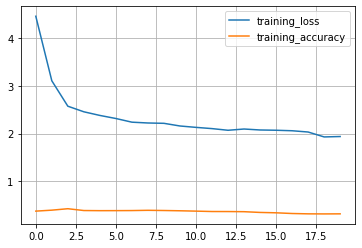

In [15]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [16]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['image']
    mask = valMap['box']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')
    
    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [17]:
sixteenPrediction, actuals, masks = predict16(dataFrame, myTransformer)

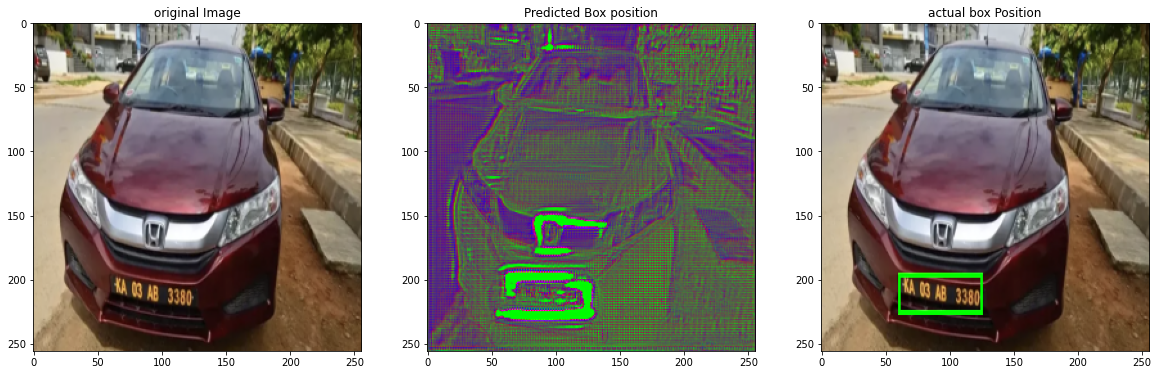

In [19]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])


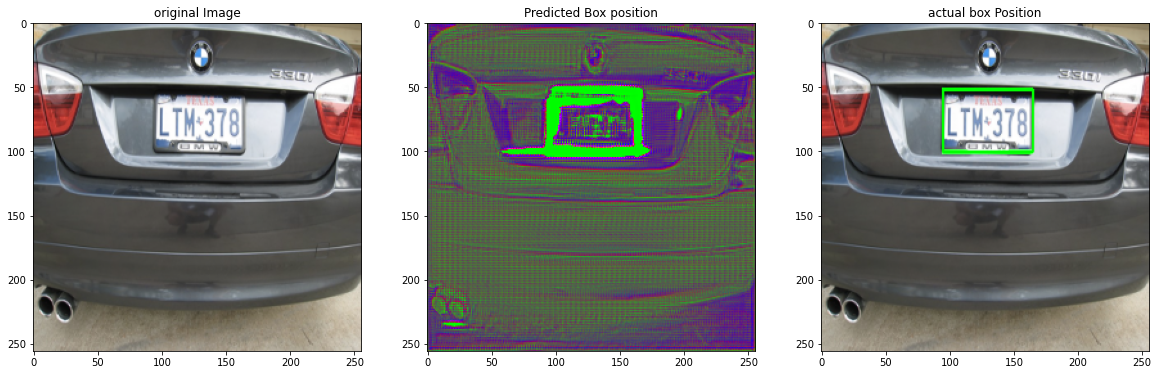

In [22]:
Plotter(actuals[10], sixteenPrediction[10], masks[10])

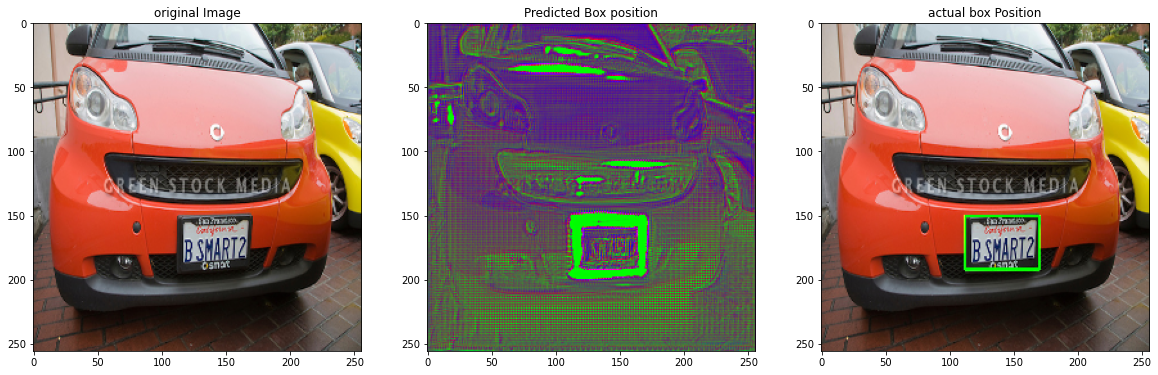

In [23]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

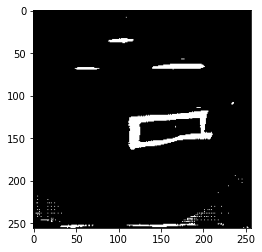

In [24]:
test = sixteenPrediction[11][:,:,1]
test [test >= 0.5] = 1
test[test != 1] = 0
plt.imshow(test, cmap = 'gray')